<a href="https://colab.research.google.com/github/Alf-caput/NFL2022_TacklePredictNN/blob/dev2/PracticaFinal_TacklingNFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import gdown
import os
id = '1V_fIjH-WGHTVgyRkdNFkZ6XxiqDoaMrA'
folder = 'nfl-big-data-bowl-2024'
endpoint = '.zip'

url = f'https://drive.google.com/uc?id={id}'

output = folder + endpoint

if not os.path.exists(output):
    gdown.download(url, output, quiet=False)

In [69]:
from zipfile import ZipFile

if not os.path.exists(folder):
	with ZipFile(output, 'r') as zObject:
		zObject.extractall(folder)

In [70]:
import pandas as pd
import os

csv_files = [file for file in os.listdir(folder) if file.endswith('.csv')]
csv_files.sort()

In [71]:
print(csv_files)

['games.csv', 'players.csv', 'plays.csv', 'tackles.csv', 'tracking_week_1.csv', 'tracking_week_2.csv', 'tracking_week_3.csv', 'tracking_week_4.csv', 'tracking_week_5.csv', 'tracking_week_6.csv', 'tracking_week_7.csv', 'tracking_week_8.csv', 'tracking_week_9.csv']


Dentro de la carpeta nfl-big-data-bowl-2024 se encuentran los csv que utilizaremos, a continuación creamos un diccionario para facilitarnos el acceso a los diferentes dataframes (dfs).

In [72]:
if 'dfs' not in locals():
    dfs = {os.path.splitext(file)[0]: pd.read_csv(os.path.join(folder, file)) for file in csv_files}

In [73]:
dfs.keys()

dict_keys(['games', 'players', 'plays', 'tackles', 'tracking_week_1', 'tracking_week_2', 'tracking_week_3', 'tracking_week_4', 'tracking_week_5', 'tracking_week_6', 'tracking_week_7', 'tracking_week_8', 'tracking_week_9'])

In [74]:
df_week1 = dfs['tracking_week_1']

game_ids = df_week1['gameId'].unique()
df_week1_game1 = df_week1[df_week1['gameId']==game_ids[0]]

play_ids = df_week1_game1['playId'].unique()
df_week1_game1_play1 = df_week1_game1[df_week1_game1['playId']==play_ids[0]]

frame_ids = df_week1_game1_play1['frameId'].unique()
df_week1_game1_play1_frame1 = df_week1_game1_play1[df_week1_game1_play1['frameId']==frame_ids[0]]

df_week1_game1_play1_frame1.head(3)

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
22,2022090800,56,38577.0,Bobby Wagner,1,2022-09-08 20:24:05.200000,45.0,LA,left,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN
44,2022090800,56,41239.0,Aaron Donald,1,2022-09-08 20:24:05.200000,99.0,LA,left,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN


In [75]:
df_week1_game1_play1_frame1.drop(columns=['displayName', 'jerseyNumber'], inplace=True)
df_week1_game1_play1_frame1.head(3)

C:\Users\alfre\AppData\Local\Temp\ipykernel_15792\3667134759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week1_game1_play1_frame1.drop(columns=['displayName', 'jerseyNumber'], inplace=True)


,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,1,2022-09-08 20:24:05.200000,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
22,2022090800,56,38577.0,1,2022-09-08 20:24:05.200000,LA,left,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN
44,2022090800,56,41239.0,1,2022-09-08 20:24:05.200000,LA,left,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN


In [76]:
df_week1_game1_play1_frame1 = pd.merge(df_week1_game1_play1_frame1, dfs['players'][['position', 'nflId']], on='nflId', how='left')
df_week1_game1_play1_frame1.head(3)

,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event,position
0,2022090800,56,35472.0,1,2022-09-08 20:24:05.200000,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN,G
1,2022090800,56,38577.0,1,2022-09-08 20:24:05.200000,LA,left,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN,ILB
2,2022090800,56,41239.0,1,2022-09-08 20:24:05.200000,LA,left,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN,DT


In [77]:
df_week1_game1_play1_frame1 = pd.merge(df_week1_game1_play1_frame1, dfs['games'][['homeTeamAbbr', 'gameId']], on='gameId', how='left')
df_week1_game1_play1_frame1.head(3)

,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event,position,homeTeamAbbr
0,2022090800,56,35472.0,1,2022-09-08 20:24:05.200000,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN,G,LA
1,2022090800,56,38577.0,1,2022-09-08 20:24:05.200000,LA,left,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN,ILB,LA
2,2022090800,56,41239.0,1,2022-09-08 20:24:05.200000,LA,left,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN,DT,LA


Como ahora sabemos el equipo local en la columna club cambiamos las abreviaturas a valor 0 (visitante) ó 1 (local) ó -1 (football)

In [78]:
df_week1_game1_play1_frame1['homeTeamAbbr'].unique()[0]

'LA'

In [79]:
local = df_week1_game1_play1_frame1['homeTeamAbbr'].unique()[0]
df_week1_game1_play1_frame1.loc[df_week1_game1_play1_frame1['club'] == 'football', 'club'] = -1
df_week1_game1_play1_frame1.loc[df_week1_game1_play1_frame1['club'] == local, 'club'] = 1
df_week1_game1_play1_frame1.loc[(df_week1_game1_play1_frame1['club'] != -1) & (df_week1_game1_play1_frame1['club'] != 1), 'club'] = 0
df_week1_game1_play1_frame1.head(3)

,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event,position,homeTeamAbbr
0,2022090800,56,35472.0,1,2022-09-08 20:24:05.200000,0,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN,G,LA
1,2022090800,56,38577.0,1,2022-09-08 20:24:05.200000,1,left,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN,ILB,LA
2,2022090800,56,41239.0,1,2022-09-08 20:24:05.200000,1,left,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN,DT,LA


Si ataca el equipo local playDirection = 1, en caso contrario (ataca equipo visitante) playDirection = 0

In [80]:
df_week1_game1_play1_frame1.loc[:, 'playDirection'] = int(df_week1_game1_play1_frame1['playDirection'].unique()[0] == 'right')
df_week1_game1_play1_frame1.head(3)

,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event,position,homeTeamAbbr
0,2022090800,56,35472.0,1,2022-09-08 20:24:05.200000,0,0,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN,G,LA
1,2022090800,56,38577.0,1,2022-09-08 20:24:05.200000,1,0,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN,ILB,LA
2,2022090800,56,41239.0,1,2022-09-08 20:24:05.200000,1,0,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN,DT,LA


Sustituimos el tiempo por el cuarto de juego en el que se encuentran y añadimos columnas con el intento (down) y el número de yardas restantes (yardsToGo)

In [81]:
df_week1_game1_play1_frame1 = pd.merge(df_week1_game1_play1_frame1, dfs['plays'][['down', 'quarter', 'yardsToGo', 'gameId', 'playId']], on=['gameId', 'playId'], how='left')
df_week1_game1_play1_frame1.drop(columns='time')
df_week1_game1_play1_frame1.head(3)

,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event,position,homeTeamAbbr,down,quarter,yardsToGo
0,2022090800,56,35472.0,1,2022-09-08 20:24:05.200000,0,0,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN,G,LA,1,1,10
1,2022090800,56,38577.0,1,2022-09-08 20:24:05.200000,1,0,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN,ILB,LA,1,1,10
2,2022090800,56,41239.0,1,2022-09-08 20:24:05.200000,1,0,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN,DT,LA,1,1,10


Ordenamos los jugadores por equipo

In [82]:
df_week1_game1_play1_frame1 = df_week1_game1_play1_frame1.sort_values(by='club', ascending=True)
df_week1_game1_play1_frame1.head(3)

,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event,position,homeTeamAbbr,down,quarter,yardsToGo
22,2022090800,56,NaN,1,2022-09-08 20:24:05.200000,-1,0,85.050003,33.810001,22.209999,11.85,2.07,NaN,NaN,NaN,NaN,LA,1,1,10
20,2022090800,56,53522.0,1,2022-09-08 20:24:05.200000,0,0,91.960000,33.010000,2.400000,2.57,0.24,23.25,117.85,NaN,T,LA,1,1,10
18,2022090800,56,52536.0,1,2022-09-08 20:24:05.200000,0,0,74.350000,7.140000,7.910000,0.79,0.79,269.06,260.37,NaN,WR,LA,1,1,10


Eliminamos la columna de equipo local, obteniendo los datos finales para un frame que utilizaremos

In [83]:
df_week1_game1_play1_frame1 = df_week1_game1_play1_frame1.drop(columns='homeTeamAbbr')
df_week1_game1_play1_frame1

,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event,position,down,quarter,yardsToGo
22,2022090800,56,NaN,1,2022-09-08 20:24:05.200000,-1,0,85.050003,33.810001,22.209999,11.85,2.07,NaN,NaN,NaN,NaN,1,1,10
20,2022090800,56,53522.0,1,2022-09-08 20:24:05.200000,0,0,91.960000,33.010000,2.400000,2.57,0.24,23.25,117.85,NaN,T,1,1,10
18,2022090800,56,52536.0,1,2022-09-08 20:24:05.200000,0,0,74.350000,7.140000,7.910000,0.79,0.79,269.06,260.37,NaN,WR,1,1,10
17,2022090800,56,48512.0,1,2022-09-08 20:24:05.200000,0,0,90.220000,32.080000,2.770000,2.46,0.28,103.24,115.97,NaN,C,1,1,10
14,2022090800,56,47879.0,1,2022-09-08 20:24:05.200000,0,0,76.540000,32.030000,6.100000,4.49,0.61,155.02,220.71,NaN,TE,1,1,10
13,2022090800,56,47857.0,1,2022-09-08 20:24:05.200000,0,0,88.170000,24.170000,1.940000,0.33,0.19,325.95,238.13,NaN,RB,1,1,10
10,2022090800,56,44985.0,1,2022-09-08 20:24:05.200000,0,0,76.700000,18.390000,4.790000,6.34,0.49,157.83,233.63,NaN,WR,1,1,10
9,2022090800,56,44875.0,1,2022-09-08 20:24:05.200000,0,0,89.420000,25.810000,1.890000,2.47,0.18,242.67,65.25,NaN,T,1,1,10
0,2022090800,56,35472.0,1,2022-09-08 20:24:05.200000,0,0,88.370000,27.270000,1.620000,1.15,0.16,231.74,147.90,NaN,G,1,1,10
4,2022090800,56,42489.0,1,2022-09-08 20:24:05.200000,0,0,80.600000,38.290000,6.230000,0.90,0.62,140.05,189.38,NaN,WR,1,1,10


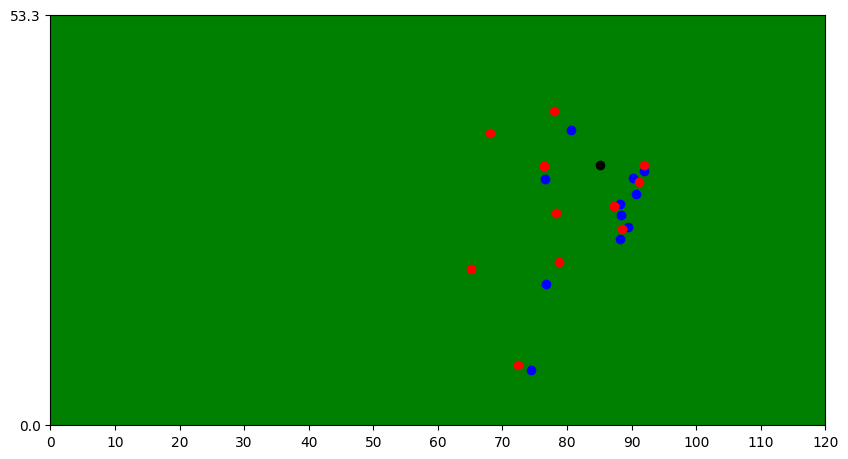

In [84]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5.33))

for i, row in df_week1_game1_play1_frame1.iterrows():
    if row['club'] == 0:
        color = 'blue'
    elif row['club'] == 1:
        color = 'red'
    else:
        color = 'black'
    ax.scatter(row['x'], row['y'], marker='o', color=color)
plt.xticks(range(0, 130, 10))
plt.yticks([0, 53.3])
ax.set_facecolor('green')

plt.show()


In [85]:
df = dfs['plays'][dfs['plays']['playId'] == 56]
print(df.values.shape)
df

(39, 35)


,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
7,2022102310,56,46377,Jeffery Wilson,(15:00) J.Wilson left tackle to SF 32 for 7 ya...,1,1,10,SF,KC,...,0.568721,0.431279,0.001382,-0.001382,1.298699,0.282340,NaN,NaN,NaN,NaN
459,2022101604,56,52584,K.J. Osborn,(15:00) K.Cousins pass short left to K.Osborn ...,1,1,10,MIN,MIA,...,0.397760,0.602240,-0.006229,0.006229,1.298699,0.438594,NaN,NaN,NaN,NaN
1398,2022091811,56,47807,Josh Jacobs,(15:00) J.Jacobs up the middle to LV 32 for 7 ...,1,1,10,LV,ARI,...,0.704539,0.295461,-0.000297,0.000297,1.298699,0.220644,NaN,NaN,NaN,NaN
1676,2022103006,56,47807,Josh Jacobs,(15:00) J.Jacobs left end to LV 26 for 1 yard ...,1,1,10,LV,NO,...,0.423747,0.576253,0.028548,-0.028548,1.298699,-0.638820,NaN,NaN,NaN,NaN
2638,2022091807,56,48374,Olamide Zaccheaus,(15:00) (Shotgun) M.Mariota pass short middle ...,1,1,10,ATL,LA,...,0.777446,0.222554,-0.009405,0.009405,1.298699,0.479512,NaN,NaN,NaN,NaN
2877,2022092506,56,43344,Tyler Boyd,(15:00) (Shotgun) J.Burrow pass short right to...,1,1,10,CIN,NYJ,...,0.295461,0.704539,-0.018068,0.018068,1.298699,0.818260,NaN,NaN,NaN,NaN
3201,2022103003,56,44947,Jamaal Williams,(15:00) (Shotgun) J.Goff pass short right to J...,1,1,10,DET,MIA,...,0.422091,0.577909,0.023051,-0.023051,1.298699,1.641564,Taunting,NaN,43503.0,NaN
3641,2022100207,56,52449,Jonathan Taylor,(15:00) J.Taylor left tackle to IND 26 for 1 y...,1,1,10,IND,TEN,...,0.637947,0.362053,-0.020433,0.020433,1.298699,-0.554432,NaN,NaN,NaN,NaN
3788,2022102000,56,52942,Juwan Johnson,(15:00) (Shotgun) A.Dalton pass short middle t...,1,1,10,NO,ARI,...,0.554282,0.445718,0.000490,-0.000490,1.298699,0.027666,NaN,NaN,NaN,NaN
4225,2022092503,56,42489,Stefon Diggs,(15:00) (Shotgun) J.Allen pass deep middle to ...,1,1,10,BUF,MIA,...,0.413347,0.586653,-0.042447,0.042447,1.298699,2.084687,NaN,NaN,NaN,NaN


In [86]:
ds = pd.concat([dfs[f'tracking_week_{i}'] for i in range(1, 10)])
ds.drop(columns=['displayName', 'jerseyNumber', 'event', 'time'], inplace=True)
ds

,gameId,playId,nflId,frameId,club,playDirection,x,y,s,a,dis,o,dir
0,2022090800,56,35472.0,1,BUF,left,88.370000,27.270000,1.62,1.15,0.16,231.74,147.90
1,2022090800,56,35472.0,2,BUF,left,88.470000,27.130000,1.67,0.61,0.17,230.98,148.53
2,2022090800,56,35472.0,3,BUF,left,88.560000,27.010000,1.57,0.49,0.15,230.98,147.05
3,2022090800,56,35472.0,4,BUF,left,88.640000,26.900000,1.44,0.89,0.14,232.38,145.42
4,2022090800,56,35472.0,5,BUF,left,88.720000,26.800000,1.29,1.24,0.13,233.36,141.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150018,2022110700,3787,NaN,40,football,right,26.219999,19.680000,1.37,2.58,0.15,NaN,NaN
1150019,2022110700,3787,NaN,41,football,right,26.320000,19.610001,1.07,2.74,0.12,NaN,NaN
1150020,2022110700,3787,NaN,42,football,right,26.389999,19.559999,0.80,2.49,0.09,NaN,NaN
1150021,2022110700,3787,NaN,43,football,right,26.450001,19.520000,0.57,2.38,0.07,NaN,NaN


In [87]:
ds.sort_values(by=['gameId', 'playId', 'frameId', 'club'], ascending=True, inplace=True)
ds

,gameId,playId,nflId,frameId,club,playDirection,x,y,s,a,dis,o,dir
0,2022090800,56,35472.0,1,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90
66,2022090800,56,42392.0,1,BUF,left,88.25,28.74,0.67,1.97,0.07,244.21,30.29
88,2022090800,56,42489.0,1,BUF,left,80.60,38.29,6.23,0.90,0.62,140.05,189.38
198,2022090800,56,44875.0,1,BUF,left,89.42,25.81,1.89,2.47,0.18,242.67,65.25
220,2022090800,56,44985.0,1,BUF,left,76.70,18.39,4.79,6.34,0.49,157.83,233.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149670,2022110700,3787,52942.0,44,NO,right,20.01,24.78,0.71,0.74,0.07,150.01,224.36
1149714,2022110700,3787,53098.0,44,NO,right,31.32,35.89,4.83,2.53,0.49,121.62,155.20
1149846,2022110700,3787,54476.0,44,NO,right,29.35,9.76,0.30,1.01,0.04,39.41,104.09
1149978,2022110700,3787,55125.0,44,NO,right,23.91,20.89,1.27,1.05,0.13,121.53,124.84
